In [14]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from torchvision.io import read_image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import timm
import kornia
import numpy as np
import os

In [15]:
# imagenet 평균, 표준편차
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
# SIGMA
SIGMA = 1.5

In [16]:
def decode_heatmap(heatmaps):
    """
    [추론용] 히트맵 -> 좌표
    """
    # Soft Argmax
    # temperature가 높을수록 argmax에 가까워지고, 낮을수록 평균에 가까워짐
    coords = kornia.geometry.subpix.spatial_soft_argmax2d(
        input=heatmaps,
        temperature=torch.tensor(1.0, device=heatmaps.device),
        normalized_coordinates=False
    )
    return coords

In [20]:
# 모델
class GaugeHRNet(nn.Module):
    def __init__(self, num_keypoints=4, pretrained=True, stride_idx=1):
        super(GaugeHRNet, self).__init__()
        self.backbone = timm.create_model(
            "hrnet_w32",
            pretrained=pretrained,
            features_only=True
        )
        self.stride_idx = stride_idx
        # Stride 4 (64x64) 특징맵 채널 수 가져오기
        in_channels = self.backbone.feature_info.channels()[self.stride_idx]

        self.final_layer = nn.Conv2d(in_channels, num_keypoints, kernel_size=1)

    def forward(self, x):
        # 특징맵 리스트 추출
        x = self.backbone(x)[self.stride_idx]
        # Stride 4 (64x64)
        x = self.final_layer(x)
        return x

In [21]:
# 설정
NUM_KEYPOINTS = 4
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# hrnet-w32
checkpoint = "models/hrnet/hrnet_w32.pth"
state_dict = torch.load(checkpoint, map_location=DEVICE)
model = GaugeHRNet(num_keypoints=NUM_KEYPOINTS).to(DEVICE)
model.load_state_dict(state_dict)

Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


<All keys matched successfully>

In [23]:
def inference(model, image_path, device, input_size=(256, 256)):
    model.eval()
    
    # 1. 이미지 로드 (Tensor [C, H, W], 0~255 uint8)
    original_image = read_image(image_path)
    _, orig_h, orig_w = original_image.shape
    
    # 2. 전처리 (학습때와 동일하게)
    # Resize
    img_tensor = F.resize(original_image, input_size)
    # [0, 1]로 스케일링
    img_tensor = img_tensor.float() / 255.0
    # Normalize
    img_tensor = T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)(img_tensor)
    # Batch 차원 추가: [C, H, W] -> [1, C, H, W]
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # 3. 모델 추론
    with torch.no_grad():
        # Output: [1, K, 64, 64] (Heatmap)
        outputs = model(img_tensor)
        
        # Heatmap -> 좌표 변환 (64x64 기준 좌표)
        pred_coords = decode_heatmap(outputs)  # [1, K, 2]

    # 4. 좌표 스케일 복원
    # 모델 출력(64x64)은 입력(256x256)의 1/4 크기이므로 4배 해줌
    pred_coords = pred_coords * 4.0
    
    # 256x256 기준 좌표를 원본 이미지 크기로 다시 변환
    scale_x = orig_w / input_size[1]
    scale_y = orig_h / input_size[0]
    
    pred_coords[0, :, 0] *= scale_x
    pred_coords[0, :, 1] *= scale_y

    return original_image, pred_coords[0]


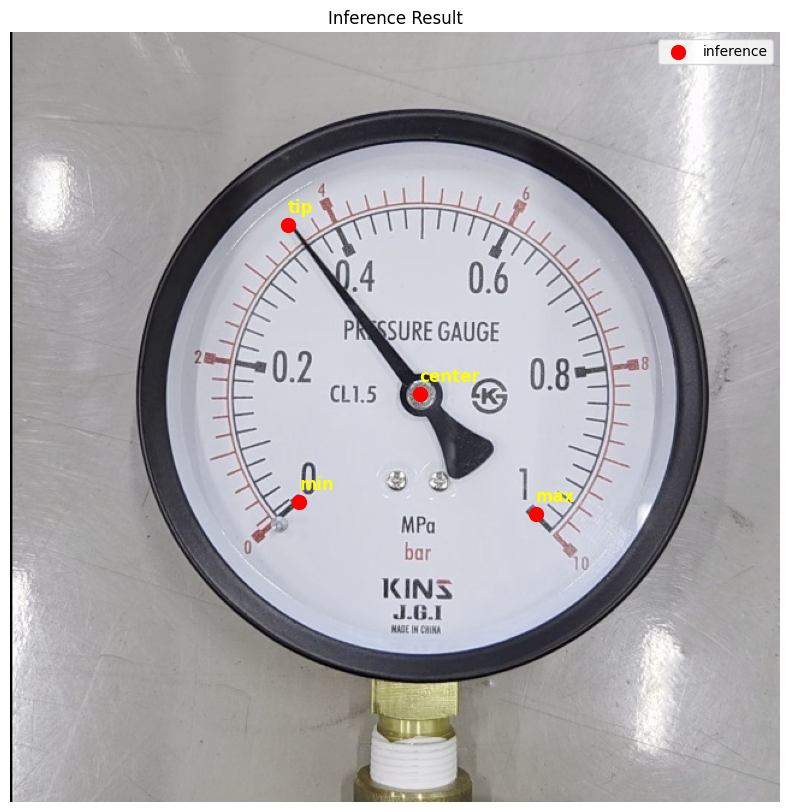

[[340.     300.    ]
 [230.4885 160.    ]
 [240.     390.    ]
 [436.6938 400.    ]]


In [24]:
test_image = "test/test6.jpg"
points = ["center", "tip", "min", "max"]

if os.path.exists(test_image):
    img_tensor, keypoints = inference(model, test_image, DEVICE)

    # tensor -> numpy
    img_numpy = img_tensor.permute(1, 2, 0).numpy()
    img_numpy = np.ascontiguousarray(img_numpy) # cv2
    
    # tensor -> numpy
    kps = keypoints.cpu().numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(img_numpy)
    
    plt.scatter(kps[:, 0], kps[:, 1], c='red', s=100, marker='o', label='inference')

    for i, (x, y) in enumerate(kps):
        plt.text(x, y - 10, f"{points[i]}", color='yellow', fontsize=12, fontweight='bold')

    plt.title("Inference Result")
    plt.legend()
    plt.axis("off")
    plt.show()

    print(kps)

else:
    print(f"이미지 파일을 찾을 수 없습니다: {test_image}")